In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType

import utils.data_processing_bronze_table_feature_clickstream
import utils.data_processing_bronze_table_features_attributes
import utils.data_processing_bronze_table_features_financials
import utils.data_processing_bronze_table_lms

import utils.data_processing_silver_table_feature_clickstream
import utils.data_processing_silver_table_features_attributes
import utils.data_processing_silver_table_lms
import utils.data_processing_silver_table_features_financials
import utils.data_processing_silver_table_aggregated

import utils.data_processing_gold_table_lms
import utils.data_processing_gold_table_features_aggregated



## set up pyspark session

In [14]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

## set up config

In [15]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2024-12-01"

In [16]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01']

## Build Bronze Tables

### Loan

In [17]:
# create bronze datalake for loan
bronze_lms_directory = "datamart/bronze/lms/"

if not os.path.exists(bronze_lms_directory):
    os.makedirs(bronze_lms_directory)

In [6]:
# run bronze backfill for loan
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_lms.process_bronze_table_lms(date_str, bronze_lms_directory, spark)


2023-01-01row count: 530
saved to: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv
2023-02-01row count: 1031
saved to: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv
2023-03-01row count: 1537
saved to: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv
2023-04-01row count: 2047
saved to: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv
2023-05-01row count: 2568
saved to: datamart/bronze/lms/bronze_loan_daily_2023_05_01.csv
2023-06-01row count: 3085
saved to: datamart/bronze/lms/bronze_loan_daily_2023_06_01.csv
2023-07-01row count: 3556
saved to: datamart/bronze/lms/bronze_loan_daily_2023_07_01.csv
2023-08-01row count: 4037
saved to: datamart/bronze/lms/bronze_loan_daily_2023_08_01.csv
2023-09-01row count: 4491
saved to: datamart/bronze/lms/bronze_loan_daily_2023_09_01.csv
2023-10-01row count: 4978
saved to: datamart/bronze/lms/bronze_loan_daily_2023_10_01.csv
2023-11-01row count: 5469
saved to: datamart/bronze/lms/bronze_loan_daily_2023_11_01.csv
2023-12-01row count: 5

In [8]:
# inspect output for loan
utils.data_processing_bronze_table_lms.process_bronze_table_lms(date_str, bronze_lms_directory, spark).toPandas()

2024-12-01row count: 5531
saved to: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv


,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000,1000.0,1000.0,0.0,1000.0,2024-12-01
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000,1000.0,0.0,6000.0,8000.0,2024-12-01
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000,1000.0,0.0,9000.0,9000.0,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000,1000.0,1000.0,0.0,2000.0,2024-12-01
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000,1000.0,1000.0,0.0,4000.0,2024-12-01
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000,0.0,0.0,0.0,10000.0,2024-12-01
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000,1000.0,1000.0,0.0,8000.0,2024-12-01


### Feature Clickstream

In [18]:
# create bronze datalake for feature clickstream
bronze_clickstream_directory = "datamart/bronze/feature_clickstream/"

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

In [10]:
# run bronze backfill for feature clickstream
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_feature_clickstream.process_bronze_table_feature_clickstream(date_str, bronze_clickstream_directory, spark)

2023-01-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_01_01.csv
2023-02-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_02_01.csv
2023-03-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_03_01.csv
2023-04-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_04_01.csv
2023-05-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_05_01.csv
2023-06-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_06_01.csv
2023-07-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_07_01.csv
2023-08-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_08_01.csv
2023-09-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_c

In [11]:
# inspect output for feature clickstream
utils.data_processing_bronze_table_feature_clickstream.process_bronze_table_feature_clickstream(date_str, bronze_clickstream_directory, spark).toPandas()

2024-12-01row count: 8974
saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2024_12_01.csv


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,414,22,72,57,142,192,11,139,24,63,...,179,91,20,189,-35,-19,15,66,CUS_0xdf6,2024-12-01
8970,116,-124,-108,212,-21,227,146,112,186,-65,...,38,226,319,98,9,152,17,14,CUS_0xe23,2024-12-01
8971,237,-3,-49,375,144,41,-170,324,19,266,...,7,102,64,191,124,220,231,75,CUS_0xe4e,2024-12-01
8972,5,67,211,83,207,-41,325,14,-18,41,...,109,266,28,157,131,116,101,131,CUS_0xedd,2024-12-01


### Features attributes

In [19]:
# create bronze datalake for feature attributes
bronze_attributes_directory = "datamart/bronze/features_attributes/"

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

In [13]:
# run bronze backfill for feature attributes
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_features_attributes.process_bronze_table_fa(date_str, bronze_attributes_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/features_attributes/bronze_attributes_2023_09_01.csv
2023-10-01row count: 487
saved to: datamart/bronze/features_attr

In [14]:
# inspect output for feature attributes
utils.data_processing_bronze_table_features_attributes.process_bronze_table_fa(date_str, bronze_attributes_directory, spark).toPandas()

2024-12-01row count: 515
saved to: datamart/bronze/features_attributes/bronze_attributes_2024_12_01.csv


,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x103e,Tim Kellyf,40,155-72-8070,Scientist,2024-12-01
1,CUS_0x1195,Alexk,31,822-48-3629,Manager,2024-12-01
2,CUS_0x1197,Nayako,28,799-23-8283,_______,2024-12-01
3,CUS_0x11e2,Valetkevitchr,34,809-04-1419,Musician,2024-12-01
4,CUS_0x11ec,William Schombergh,34,417-74-2163,Journalist,2024-12-01
...,...,...,...,...,...,...
510,CUS_0xe6c,Doris Frankelh,26,172-24-1577,Entrepreneur,2024-12-01
511,CUS_0xe99,Moone,48,164-90-3178,Mechanic,2024-12-01
512,CUS_0xf55,Tarmo Virkip,39,025-54-8593,Entrepreneur,2024-12-01
513,CUS_0xfd1,Frewy,32,389-55-6408,Architect,2024-12-01


### Features financials

In [20]:
# create bronze datalake for feature financials
bronze_financials_directory = "datamart/bronze/features_financials/"

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [16]:
# run bronze backfill for feature financials
for date_str in dates_str_lst:
    utils.data_processing_bronze_table_features_financials.process_bronze_table_features_financials(date_str, bronze_financials_directory, spark)

2023-01-01row count: 530
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_01_01.csv
2023-02-01row count: 501
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_02_01.csv
2023-03-01row count: 506
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_03_01.csv
2023-04-01row count: 510
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_04_01.csv
2023-05-01row count: 521
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_05_01.csv
2023-06-01row count: 517
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_06_01.csv
2023-07-01row count: 471
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_07_01.csv
2023-08-01row count: 481
saved to: datamart/bronze/features_financials/bronze_features_financials_2023_08_01.csv
2023-09-01row count: 454
saved to: datamart/bronze/features_financials/bronze_features_financial

In [18]:
# inspect output for feature clickstream
utils.data_processing_bronze_table_features_financials.process_bronze_table_features_financials(date_str, bronze_clickstream_directory, spark).toPandas()

2024-12-01row count: 515
saved to: datamart/bronze/feature_clickstream/bronze_features_financials_2024_12_01.csv


,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x103e,98690.8,8262.233333,4,6,9,1_,Student Loan,6,17,...,Good,706.96,26.860663,26 Years and 11 Months,No,55.004408,913.4813186573292,Low_spent_Small_value_payments,147.7376071067124,2024-12-01
1,CUS_0x1195,30429.91,2808.825833,4,6,16,2,"Auto Loan, and Auto Loan",22,17,...,Standard,362.48,33.349050,28 Years and 11 Months,No,29.914076,82.87878577514347,Low_spent_Large_value_payments,438.08972109416084,2024-12-01
2,CUS_0x1197,92300.01,7437.667500,2,4,11,3,"Credit-Builder Loan, Not Specified, and Credit...",27,9,...,_,755.17_,26.989787,18 Years and 11 Months,Yes,49236.000000,220.8621525417414,Low_spent_Large_value_payments,581.1567885447394,2024-12-01
3,CUS_0x11e2,44986.55,3689.879167,6,5,11,1,Credit-Builder Loan,0,4,...,Good,753.21,25.586286,20 Years and 0 Months,No,23.267135,43.20363344633164,High_spent_Large_value_payments,542.5171477430948,2024-12-01
4,CUS_0x11ec,14867.69,1005.974167,9,9,18,6,"Debt Consolidation Loan, Student Loan, Persona...",39,15,...,Standard,2344.06,24.344388,17 Years and 2 Months,Yes,55.459604,100.14574834721886,Low_spent_Medium_value_payments,224.99206407779144,2024-12-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0xe6c,125597.52,9367.500187,1,3,12,4,"Debt Consolidation Loan, Not Specified, Studen...",2,9,...,Good,1294.94,30.324257,30 Years and 5 Months,NM,1278.186251,964.5381161830327,Low_spent_Medium_value_payments,763.3982127892344,2024-12-01
511,CUS_0xe99,45461.54,3917.461667,6,3,5,2,"Credit-Builder Loan, and Payday Loan",20,9,...,Standard,647.24,27.264685,16 Years and 9 Months,No,69.318349,42.941001590068666,High_spent_Large_value_payments,519.4868162135749,2024-12-01
512,CUS_0xf55,78443.48_,6358.956667,7,5,23,4,"Personal Loan, Home Equity Loan, Mortgage Loan...",39,19,...,Bad,1527.77,24.704429,15 Years and 10 Months,NM,177.387563,528.7469053018515,Low_spent_Medium_value_payments,209.76119880079318,2024-12-01
513,CUS_0xfd1,78666.56999999999,6485.547500,3,4,17,4,"Not Specified, Personal Loan, Home Equity Loan...",29,10,...,Standard,1498.7,37.831762,22 Years and 5 Months,No,247.851145,252.3461368272953,High_spent_Small_value_payments,408.35746850506007,2024-12-01


## Build Silver Table

### Loan

In [21]:
# create silver datalake
silver_loan_daily_directory = "datamart/silver/loan_daily/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)

In [20]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_lms.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark)


loaded from: datamart/bronze/lms/bronze_loan_daily_2023_01_01.csv row count: 530
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']


saved to: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_02_01.csv row count: 1031
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_03_01.csv row count: 1537
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_04_01.csv row count: 2047
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt',

saved to: datamart/silver/loan_daily/silver_loan_daily_2023_09_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_10_01.csv row count: 4978
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_10_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_11_01.csv row count: 5469
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']


saved to: datamart/silver/loan_daily/silver_loan_daily_2023_11_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2023_12_01.csv row count: 5428
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2023_12_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_01_01.csv row count: 5412
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_01_01.parquet
loaded from: datamart/bronze/lms/bronze_loan_daily_2024_02_01.csv row count: 5424
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt',

In [21]:
utils.data_processing_silver_table_lms.process_silver_table(date_str, bronze_lms_directory, silver_loan_daily_directory, spark).toPandas()

loaded from: datamart/bronze/lms/bronze_loan_daily_2024_12_01.csv row count: 5531
Columns renamed. Current columns: ['loan_id', 'customer_id', 'loan_start_date', 'tenure', 'installment_num', 'loan_amt', 'due_amt', 'paid_amt', 'overdue_amt', 'balance', 'snapshot_date']
saved to: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet


,loan_id,customer_id,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,9,10000.0,1000.0,1000.0,0.0,1000.0,2024-12-01,9,0,None,0
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,8,10000.0,1000.0,0.0,6000.0,8000.0,2024-12-01,8,6,2024-06-01,183
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
4,CUS_0x1048_2024_02_01,CUS_0x1048,2024-02-01,10,10,10000.0,1000.0,0.0,9000.0,9000.0,2024-12-01,10,9,2024-03-01,275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5526,CUS_0xfe3_2024_04_01,CUS_0xfe3,2024-04-01,10,8,10000.0,1000.0,1000.0,0.0,2000.0,2024-12-01,8,0,None,0
5527,CUS_0xff3_2024_06_01,CUS_0xff3,2024-06-01,10,6,10000.0,1000.0,1000.0,0.0,4000.0,2024-12-01,6,0,None,0
5528,CUS_0xff4_2024_12_01,CUS_0xff4,2024-12-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2024-12-01,0,0,None,0
5529,CUS_0xff6_2024_10_01,CUS_0xff6,2024-10-01,10,2,10000.0,1000.0,1000.0,0.0,8000.0,2024-12-01,2,0,None,0


## Loan EDA on credit labels

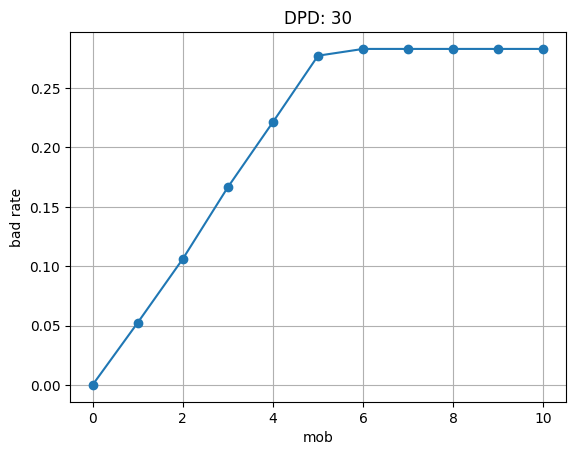

In [22]:
# set dpd label definition
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2024-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# prepare for analysis
# df = df.filter(col("installment_num") < 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [23]:
df.show()

+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|             loan_id|customer_id|loan_start_date|tenure|installment_num|loan_amt|due_amt|paid_amt|overdue_amt|balance|snapshot_date|mob|installments_missed|first_missed_date|dpd|dpd_flag|
+--------------------+-----------+---------------+------+---------------+--------+-------+--------+-----------+-------+-------------+---+-------------------+-----------------+---+--------+
|CUS_0x1011_2023_1...| CUS_0x1011|     2023-11-01|    10|             10| 10000.0| 1000.0|  1000.0|        0.0|    0.0|   2024-09-01| 10|                  0|             NULL|  0|       0|
|CUS_0x1013_2023_1...| CUS_0x1013|     2023-12-01|    10|              9| 10000.0| 1000.0|  1000.0|        0.0| 1000.0|   2024-09-01|  9|                  0|             NULL|  0|       0|
|CUS_0x1018_2023_1...| CUS_0x1018|     2023-11-01|    1

### Click stream

In [22]:
# create silver datalake for feature clickstream
silver_clickstream_directory = "datamart/silver/feature_clickstream/"

if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

In [11]:
    # run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_feature_clickstream.process_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, silver_loan_daily_directory,spark)

loaded bronze clickstream from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_01_01.csv row count: 8974
loaded silver loan data from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
Extracted unique loan keys: 530
Joined clickstream records (after INNER JOIN): 530
saved silver clickstream data to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_01_01.parquet
loaded bronze clickstream from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_02_01.csv row count: 8974
loaded silver loan data from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031
Extracted unique loan keys: 1031
Joined clickstream records (after INNER JOIN): 501
saved silver clickstream data to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_02_01.parquet
loaded bronze clickstream from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_03_01.csv row count: 8974
load

Noted that subsequent to July 2024, alot of customer information does not have clickstream data coming in. 

In [27]:
utils.data_processing_silver_table_feature_clickstream.process_silver_table(date_str, bronze_clickstream_directory, silver_clickstream_directory, silver_loan_daily_directory,spark).toPandas()

loaded bronze clickstream from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2024_12_01.csv row count: 8974
loaded silver loan data from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
Extracted unique loan keys: 5531
Joined clickstream records (after INNER JOIN): 0
saved silver clickstream data to: datamart/silver/feature_clickstream/silver_feature_clickstream_2024_12_01.parquet


,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,customer_id,snapshot_date,loan_id


### Features Attributes

In [23]:
# create silver datalake for feature attributes
silver_attributes_directory = "datamart/silver/features_attributes/"

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

In [14]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_features_attributes.process_silver_table_features_attributes(date_str, bronze_attributes_directory, silver_attributes_directory, spark)

loaded from: datamart/bronze/features_attributes/bronze_attributes_2023_01_01.csv row count: 530
Found 15 unique occupations to one-hot encode.


saved to: datamart/silver/features_attributes/silver_attributes_2023_01_01.parquet
Final schema after one-hot encoding:
root
 |-- customer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ssn: string (nullable = true)
 |-- snapshot_date: date (nullable = false)
 |-- occupation_scientist: integer (nullable = true)
 |-- occupation_musician: integer (nullable = true)
 |-- occupation_lawyer: integer (nullable = true)
 |-- occupation_teacher: integer (nullable = true)
 |-- occupation_developer: integer (nullable = true)
 |-- occupation_writer: integer (nullable = true)
 |-- occupation_architect: integer (nullable = true)
 |-- occupation_mechanic: integer (nullable = true)
 |-- occupation_entrepreneur: integer (nullable = true)
 |-- occupation_journalist: integer (nullable = true)
 |-- occupation_doctor: integer (nullable = true)
 |-- occupation_mediamanager: integer (nullable = true)
 |-- occupation_engineer: integer (nullable = true)

In [15]:
utils.data_processing_silver_table_features_attributes.process_silver_table_features_attributes(date_str, bronze_attributes_directory, silver_attributes_directory, spark).toPandas()

loaded from: datamart/bronze/features_attributes/bronze_attributes_2024_12_01.csv row count: 515
Found 15 unique occupations to one-hot encode.
saved to: datamart/silver/features_attributes/silver_attributes_2024_12_01.parquet
Final schema after one-hot encoding:
root
 |-- customer_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ssn: string (nullable = true)
 |-- snapshot_date: date (nullable = false)
 |-- occupation_scientist: integer (nullable = true)
 |-- occupation_musician: integer (nullable = true)
 |-- occupation_lawyer: integer (nullable = true)
 |-- occupation_teacher: integer (nullable = true)
 |-- occupation_developer: integer (nullable = true)
 |-- occupation_writer: integer (nullable = true)
 |-- occupation_architect: integer (nullable = true)
 |-- occupation_mechanic: integer (nullable = true)
 |-- occupation_entrepreneur: integer (nullable = true)
 |-- occupation_journalist: integer (nullable = true)
 |-- occupati

,customer_id,name,age,ssn,snapshot_date,occupation_scientist,occupation_musician,occupation_lawyer,occupation_teacher,occupation_developer,occupation_writer,occupation_architect,occupation_mechanic,occupation_entrepreneur,occupation_journalist,occupation_doctor,occupation_mediamanager,occupation_engineer,occupation_accountant,occupation_manager
0,CUS_0x8b4f,rar,36,948-26-2105,2024-12-01,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,CUS_0x86b,Paulr,42,372-37-8955,2024-12-01,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,CUS_0x2555,Dan Wilchinsr,24,373-90-7239,2024-12-01,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,CUS_0x6ef2,Leongi,21,187-39-3355,2024-12-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,CUS_0xba8,Klaymanh,26,777-03-1147,2024-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0x7577,Janab,55,466-42-9476,2024-12-01,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
511,CUS_0x87c2,Sarah N.c,53,802-97-1200,2024-12-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
512,CUS_0xc042,Doulatramaniq,31,None,2024-12-01,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
513,CUS_0x1d63,Natec,18,836-01-6064,2024-12-01,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


### Features Financials

In [24]:
# create silver datalake for feature financials
silver_financials_directory = "datamart/silver/features_financials/"

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [25]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_features_financials.process_silver_table(date_str, bronze_financials_directory, silver_financials_directory, spark)

loaded from: datamart/bronze/features_financials/bronze_features_financials_2023_01_01.csv row count: 530

--- 99.9th Percentile (Outlier Thresholds) for EDA ---
{'amount_invested_monthly': 10000.0,
 'annual_income': 17706148.0,
 'changed_credit_limit': 31.579999923706055,
 'credit_utilization_ratio': 46.77126693725586,
 'monthly_balance': 1396.8818359375,
 'monthly_inhand_salary': 14601.51953125,
 'outstanding_debt': 4980.31005859375,
 'total_emi_per_month': 80768.0}
-----------------------------------------------------

Applying custom clipping and validation rules...
Applying 99.9th percentile clipping...
Renaming loan type columns to snake_case...
Overwriting 'num_of_loan' with calculated count from loan types.

--- Final Schema ---
root
 |-- customer_id: string (nullable = true)
 |-- annual_income: float (nullable = false)
 |-- monthly_inhand_salary: float (nullable = false)
 |-- num_bank_accounts: integer (nullable = true)
 |-- num_credit_card: integer (nullable = true)
 |-- inte

saved to: datamart/silver/features_financials/silver_features_financials_2023_01_01.parquet final row count: 530
loaded from: datamart/bronze/features_financials/bronze_features_financials_2023_02_01.csv row count: 501

--- 99.9th Percentile (Outlier Thresholds) for EDA ---
{'amount_invested_monthly': 10000.0,
 'annual_income': 22409880.0,
 'changed_credit_limit': 33.849998474121094,
 'credit_utilization_ratio': 44.710662841796875,
 'monthly_balance': 1254.0257568359375,
 'monthly_inhand_salary': 14754.9931640625,
 'outstanding_debt': 4970.14013671875,
 'total_emi_per_month': 81760.0}
-----------------------------------------------------

Applying custom clipping and validation rules...
Applying 99.9th percentile clipping...
Renaming loan type columns to snake_case...
Overwriting 'num_of_loan' with calculated count from loan types.

--- Final Schema ---
root
 |-- customer_id: string (nullable = true)
 |-- annual_income: float (nullable = false)
 |-- monthly_inhand_salary: float (nullab

In [26]:
utils.data_processing_silver_table_features_financials.process_silver_table(date_str, bronze_financials_directory, silver_financials_directory, spark).toPandas()

loaded from: datamart/bronze/features_financials/bronze_features_financials_2024_12_01.csv row count: 515

--- 99.9th Percentile (Outlier Thresholds) for EDA ---
{'amount_invested_monthly': 10000.0,
 'annual_income': 17655552.0,
 'changed_credit_limit': 31.920000076293945,
 'credit_utilization_ratio': 45.78398895263672,
 'monthly_balance': 1400.4263916015625,
 'monthly_inhand_salary': 14978.3369140625,
 'outstanding_debt': 4862.7998046875,
 'total_emi_per_month': 70242.0}
-----------------------------------------------------

Applying custom clipping and validation rules...
Applying 99.9th percentile clipping...
Renaming loan type columns to snake_case...
Overwriting 'num_of_loan' with calculated count from loan types.

--- Final Schema ---
root
 |-- customer_id: string (nullable = true)
 |-- annual_income: float (nullable = false)
 |-- monthly_inhand_salary: float (nullable = false)
 |-- num_bank_accounts: integer (nullable = true)
 |-- num_credit_card: integer (nullable = true)
 |-- 

,customer_id,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,...,loan_type_count_sum,auto_loan,credit_builder_loan,debt_consolidation_loan,home_equity_loan,mortgage_loan,not_specified,payday_loan,personal_loan,student_loan
0,CUS_0xb1d2,61737.941406,4888.828125,5,3,20,2,13,20,8.38,...,2,0,0,1,0,0,0,0,0,1
1,CUS_0xb4cc,48434.660156,4201.221680,5,5,5,1,12,9,11.44,...,1,0,0,0,0,0,1,0,0,0
2,CUS_0x3172,117724.156250,9778.346680,1,5,10,1,13,11,10.26,...,1,1,0,0,0,0,0,0,0,0
3,CUS_0x7d6f,21454.720703,1656.893311,3,4,5,2,26,10,10.36,...,2,0,0,0,0,0,0,1,1,0
4,CUS_0x42e4,28204.789062,2066.399170,2,6,5,1,26,9,4.64,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,CUS_0x8109,179068.046875,14978.336914,5,6,6,3,30,11,11.86,...,3,1,0,0,0,1,0,0,1,0
511,CUS_0x1c0c,114148.242188,9579.353516,6,4,5,1,7,19,13.15,...,1,1,0,0,0,0,0,0,0,0
512,CUS_0x5b0a,21524.210938,1720.684204,8,7,17,1,27,9,18.83,...,1,0,0,0,0,0,0,0,1,0
513,CUS_0xb884,28475.189453,2090.932617,5,4,40,3,10,18,11.96,...,3,0,1,1,1,0,0,0,0,0


### Aggregated features silver

In [27]:
# create silver datalake for feature financials
silver_aggregated_directory = "datamart/silver/features_aggregated/"

if not os.path.exists(silver_aggregated_directory):
    os.makedirs(silver_aggregated_directory)

In [28]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table_aggregated.process_silver_aggregation(date_str, silver_clickstream_directory, silver_attributes_directory, silver_financials_directory, silver_aggregated_directory, spark)

Reading clickstream data from: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_01_01.parquet
Reading attributes data from: datamart/silver/features_attributes/silver_attributes_2023_01_01.parquet
Reading financials data from: datamart/silver/features_financials/silver_features_financials_2023_01_01.parquet
Loaded clickstream data. Row count: 530
Loaded attributes data. Row count: 530
Loaded financials data. Row count: 530
Row count after joining attributes and financials: 530
Row count after final join with clickstream: 530
Final aggregated schema:
root
 |-- customer_id: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ssn: string (nullable = true)
 |-- occupation_scientist: integer (nullable = true)
 |-- occupation_musician: integer (nullable = true)
 |-- occupation_lawyer: integer (nullable = true)
 |-- occupation_teacher: integer (nullable = true)
 |-- occupation_devel

In [29]:
utils.data_processing_silver_table_aggregated.process_silver_aggregation("2023-01-01", silver_clickstream_directory, silver_attributes_directory, silver_financials_directory, silver_aggregated_directory, spark).toPandas()

Reading clickstream data from: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_01_01.parquet
Reading attributes data from: datamart/silver/features_attributes/silver_attributes_2023_01_01.parquet
Reading financials data from: datamart/silver/features_financials/silver_features_financials_2023_01_01.parquet
Loaded clickstream data. Row count: 530
Loaded attributes data. Row count: 530
Loaded financials data. Row count: 530
Row count after joining attributes and financials: 530
Row count after final join with clickstream: 530
Final aggregated schema:
root
 |-- customer_id: string (nullable = true)
 |-- snapshot_date: date (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- ssn: string (nullable = true)
 |-- occupation_scientist: integer (nullable = true)
 |-- occupation_musician: integer (nullable = true)
 |-- occupation_lawyer: integer (nullable = true)
 |-- occupation_teacher: integer (nullable = true)
 |-- occupation_devel

,customer_id,snapshot_date,name,age,ssn,occupation_scientist,occupation_musician,occupation_lawyer,occupation_teacher,occupation_developer,...,fe_12,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,loan_id
0,CUS_0xa146,2023-01-01,"""""""""""""""Martinf""""""",23,146-83-0280,0,0,0,0,0,...,248,95,-48,208,-82,211,193,58,109,CUS_0xa146_2023_01_01
1,CUS_0x7a77,2023-01-01,Huw Jonesq,24,044-19-7799,0,1,0,0,0,...,171,228,125,81,300,27,47,-64,234,CUS_0x7a77_2023_01_01
2,CUS_0xdfb,2023-01-01,Robin Emmottu,37,080-47-2722,0,0,0,0,0,...,124,196,212,108,20,159,115,97,111,CUS_0xdfb_2023_01_01
3,CUS_0xc4c3,2023-01-01,Megan Daviesf,54,718-68-7156,0,0,0,0,0,...,121,98,66,228,-6,10,137,121,162,CUS_0xc4c3_2023_01_01
4,CUS_0x52a5,2023-01-01,Ross Kerberh,33,749-66-2495,0,0,0,0,0,...,186,-47,88,169,-54,155,4,-37,-4,CUS_0x52a5_2023_01_01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525,CUS_0x5f02,2023-01-01,Lynni,31,284-27-3237,0,0,0,1,0,...,44,74,229,96,160,112,142,239,-37,CUS_0x5f02_2023_01_01
526,CUS_0x24c3,2023-01-01,Thomasj,52,484-34-7482,0,0,0,0,0,...,256,318,90,282,281,244,326,129,59,CUS_0x24c3_2023_01_01
527,CUS_0x9a55,2023-01-01,Kathyy,43,371-02-6134,1,0,0,0,0,...,43,47,196,93,171,72,134,-32,56,CUS_0x9a55_2023_01_01
528,CUS_0x846a,2023-01-01,Aruna Viswanathab,52,603-04-5885,0,0,0,0,0,...,259,122,237,17,61,144,-14,121,13,CUS_0x846a_2023_01_01


## Build gold table for labels

In [18]:
# create gold datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [20]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table_lms.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)


loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_01_01.parquet row count: 530
saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_02_01.parquet row count: 1031
saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_03_01.parquet row count: 1537
saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_04_01.parquet row count: 2047
saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_05_01.parquet row count: 2568
saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/loan_daily/silver_loan_daily_2023_06_01.parquet row count: 3085
saved to: datamart/gold/label_store/gold_label_store_2023_06_01.parquet
loaded from

In [21]:
utils.data_processing_gold_table_lms.process_labels_gold_table(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6).dtypes


loaded from: datamart/silver/loan_daily/silver_loan_daily_2024_12_01.parquet row count: 5531
saved to: datamart/gold/label_store/gold_label_store_2024_12_01.parquet


[('loan_id', 'string'),
 ('Customer_ID', 'string'),
 ('label', 'int'),
 ('label_def', 'string'),
 ('snapshot_date', 'date')]

## inspect label store

In [22]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x1037_2023_0...| CUS_0x1037|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1069_2023_0...| CUS_0x1069|    0|30dpd_6mob|   2023-07-01|
|CUS_0x114a_2023_0...| CUS_0x114a|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1184_2023_0...| CUS_0x1184|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1297_2023_0...| CUS_0x1297|    1|30dpd_6mob|   2023-07-01|
|CUS_0x12fb_2023_0...| CUS_0x12fb|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1325_2023_0...| CUS_0x1325|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1341_2023_0...| CUS_0x1341|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1375_2023_0...| CUS_0x1375|    1|30dpd_6mob|   2023-07-01|
|CUS_0x13a8_2023_0...| CUS_0x13a8|    0|30dpd_6mob|   2023-07-01|
|CUS_0x13ef_2023_0...| CUS_0x13ef|    0|30dpd_6mob|   2023-07-01|
|CUS_0x1440_2023_0...| CUS_0x1440|    0|30dpd_6mob|   2023-0

In [23]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)



### Gold table for features

In [30]:
# create gold datalake
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [31]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table_features_aggregated.process_gold_feature_store(date_str, silver_aggregated_directory, gold_feature_store_directory, spark)

Reading aggregated Silver data from: datamart/silver/features_aggregated/silver_features_aggregated_2023_01_01.parquet
Loaded Silver aggregated data. Row count: 530
Dropped columns: ['name', 'ssn', 'credit_mix', 'num_of_loan', 'credit_history_years', 'credit_history_months', 'payment_behaviour', 'credit_history_age']
Gold layer processing complete. Final column count: 69

--- Null Analysis for df_gold_feature_store (Total Rows: 530) ---
✅ Success: No columns contain null values.
------------------------------------------------------------------

Saving Gold layer data to: datamart/gold/feature_store/gold_feature_store_2023_01_01.parquet
Successfully saved Gold layer table.
Reading aggregated Silver data from: datamart/silver/features_aggregated/silver_features_aggregated_2023_02_01.parquet
Loaded Silver aggregated data. Row count: 501
Dropped columns: ['name', 'ssn', 'credit_mix', 'num_of_loan', 'credit_history_years', 'credit_history_months', 'payment_behaviour', 'credit_history_age']

In [32]:
folder_path = gold_feature_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 8974
+-----------+-------------+----+--------------------+-------------------+-----------------+------------------+--------------------+-----------------+--------------------+-------------------+-----------------------+---------------------+-----------------+-----------------------+-------------------+---------------------+------------------+-------------+---------------------+-----------------+---------------+-------------+-------------------+----------------------+--------------------+--------------------+----------------+------------------------+---------------------+-------------------+-----------------------+---------------+------------------+---------------------------+----------------------+-------------------------+-------------------+---------+-------------------+-----------------------+----------------+-------------+-------------+-----------+-------------+------------+----+----+----+----+----+----+----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----